In [182]:
!python3 --version

Python 3.10.14


In [183]:
!pip install pyqubo

In [184]:
!pip install openjij jijmodeling_transpiler

In [185]:
!pip show pyqubo

Name: pyqubo
Version: 1.4.0
Summary: PyQUBO allows you to create QUBOs or Ising models from mathematical expressions.
Home-page: https://github.com/recruit-communications/pyqubo
Author: Recruit Co., Ltd.
Author-email: rco_pyqubo@ml.cocorou.jp
License: Apache 2.0
Location: /Users/aaaaa/.pyenv/versions/3.10.14/lib/python3.10/site-packages
Requires: Deprecated, dimod, dwave-neal, numpy, six
Required-by: jijmodeling-transpiler


In [340]:
from pyqubo import Array, Placeholder, solve_ising, Constraint, SubH, Model, Binary
import re, random, math
import numpy as np
import openjij as oj
import time 

In [341]:
def assign_resource_num(resource):
    resource_num = {}
    cnt = 0
    for i in resource:
        for j in resource[i]:
            resource_num[j] = cnt
            cnt += 1
    return resource_num

In [342]:
resource_m = {'R0': ['m11', 'm12'], 'R1': ['m21', 'm22'], 'R2': ['m31', 'm32']}
machine_processing_time = {'m11': 1, 'm12': 2, 'm21': 3, 'm22': 1, 'm31': 1, 'm32': 3}
machine_cost = {'m11': 10, 'm12': 14, 'm21': 13, 'm22': 10, 'm31': 12, 'm32': 10}

resource_num = assign_resource_num(resource_m)

resource_num

{'m11': 0, 'm12': 1, 'm21': 2, 'm22': 3, 'm31': 4, 'm32': 5}

In [343]:
# スケジューリング問題のjobリソースを生成
def generate_jobs_and_resources(num_jobs, seed=None):
    resource_t = {'R0': [], 'R1': [], 'R2': []}
    place = []
    job = []
    job_tasks = {}  # タスク長を格納する辞書

    # シードを設定（指定された場合のみ）
    if seed is not None:
        random.seed(seed)

    for i in range(1, num_jobs + 1):
        t11 = f't{i}1'
        t12 = f't{i}2'
        t13 = f't{i}3'

        job.append([t11, t12, t13])

        resource_t['R0'].append(t11)
        resource_t['R1'].append(t12)
        resource_t['R2'].append(t13)

        place.append([f'p{i}1', f'p{i}2', f'p{i}3', f'p{i}4'])

        # 各タスクに1から10の範囲でランダムなタスク長を割り当てる
        job_tasks[t11] = random.randint(1, 10)  # t11にランダムなタスク長を割り当て
        job_tasks[t12] = random.randint(1, 10)  # t12にランダムなタスク長を割り当て
        job_tasks[t13] = random.randint(1, 10)  # t13にランダムなタスク長を割り当て

    return resource_t, place, job, job_tasks

In [344]:
# R0, R1, R2ごとにマシンごとのタスク処理時間を保存する関数
def calculate_task_matrix(job_tasks, resource_t, resource_m, machine_processing_time):
    matrices = {}

    # 各リソースごとにマシンごとの行列を作成
    for resource, tasks in resource_t.items():
        machines = resource_m[resource]  # リソースに対応するマシンリスト
        num_tasks = len(tasks)
        num_machines = len(machines)

        # 結果を保存する行列（タスク数×マシン数）
        result_matrix = np.zeros((num_tasks, num_machines))

        for task_idx, task in enumerate(tasks):
            task_duration = job_tasks[task]  # タスクの処理時間を取得

            for machine_idx, machine in enumerate(machines):
                machine_time = machine_processing_time[machine]  # マシンの処理時間を取得

                # タスク長をマシン処理時間で割る
                result_matrix[task_idx, machine_idx] = task_duration / machine_time

        # リソースごとに行列を保存
        matrices[resource] = result_matrix

    return matrices

In [345]:
def calculate_machine_cost_matrix(resource_t, resource_m, machine_cost):
    matrices = {}

    # 各リソースごとにマシンごとの行列を作成
    for resource, tasks in resource_t.items():
        machines = resource_m[resource]  # リソースに対応するマシンリスト
        num_tasks = len(tasks)
        num_machines = len(machines)

        # 結果を保存する行列（タスク数×マシン数）
        result_matrix = np.zeros((num_tasks, num_machines))

        for machine_idx, machine in enumerate(machines):
            machine_cost_value = machine_cost[machine]  # マシンのコストを取得

            # 全タスクに対して同じマシンコストを適用
            result_matrix[:, machine_idx] = machine_cost_value

        # リソースごとに行列を保存
        matrices[resource] = result_matrix

    return matrices

In [346]:
num_jobs = 5
resource_t, place, job, job_tasks = generate_jobs_and_resources(num_jobs, seed=42)
time = 30

In [347]:
transition_num = {}
cnt = 0
for i in job:
    for j in i:
        transition_num[j] = cnt
        cnt += 1
transition_num

{'t11': 0,
 't12': 1,
 't13': 2,
 't21': 3,
 't22': 4,
 't23': 5,
 't31': 6,
 't32': 7,
 't33': 8,
 't41': 9,
 't42': 10,
 't43': 11,
 't51': 12,
 't52': 13,
 't53': 14}

In [348]:
# 各リソースごとにタスクの処理時間をマシンで割った行列を計算
task_matrices = calculate_task_matrix(job_tasks, resource_t, resource_m, machine_processing_time)

In [349]:
# 各リソースごとにタスクの処理時間をマシンで割った行列を計算
cost_matrices = calculate_machine_cost_matrix(resource_t, resource_m, machine_processing_time)

In [350]:
def assign_tasks_to_machines(best_solution, task_number, num_tasks):
    schedule_dict = {}  # タスクとマシンの割り当てを格納する辞書

    for idx, value in best_solution.items():
        if value == 1:  # 値が1のときのみ格納
            machine_index = idx // num_tasks  # マシンインデックスを計算
            task_index = idx % num_tasks      # タスクインデックスを計算
            task_name = f't{task_index + 1}{task_number}'  # タスク番号はtask_number
            
            # マシン名を生成
            machine_name = f'm{task_number}{machine_index + 1}'
            
            # タスクとマシンの対応を辞書に保存
            schedule_dict[task_name] = machine_name

    return schedule_dict

In [351]:
# 各トランジションの処理時間の最大・最小値を求める関数
def calculate_time_ranges(job, job_tasks, task_resources, machine_processing_time, total_time):
    range_trantision_ptime = {}

    # 各ジョブに対して処理を行う
    for idx, j in enumerate(job):
        # 最後のタスクの上限は total_time になる
        ub = total_time
        
        for i in reversed(range(len(j))):  # タスクを逆順に処理
            task = j[i]

            # 下限（lb）の計算: 現在のタスクまでの合計処理時間（小数点を切り上げ）
            lb = 0
            if i != 0:
                lb = sum([math.ceil(job_tasks[j[k]] / machine_processing_time[task_resources[j[k]]]) for k in range(i)])

            # 上限（ub）の計算: 次のタスクの上限から現在のタスクの処理時間を引く
            if i < len(j) - 1:  # 最後のタスクでない場合
                ub -= math.ceil(job_tasks[task] / machine_processing_time[task_resources[task]])

            # 計算結果を保存
            range_trantision_ptime[task] = [lb, ub]

    # 指定された順序でタスクを整列
    ordered_keys = sorted(range_trantision_ptime.keys(), key=lambda x: (int(x[1:]), int(x[2:])))
    ordered_ranges = {key: range_trantision_ptime[key] for key in ordered_keys}

    return ordered_ranges

## マシンリソースの割り当ての目的関数

In [352]:
import jijmodeling as jm
import jijmodeling_transpiler as jmt

# 問題の定義
problem = jm.Problem("Task Scheduling")

# プレースホルダーとバイナリ変数の定義
M = task_matrices['R0'].ndim  # マシンの数
T = task_matrices['R0'].shape[0]  # タスクの数
a = jm.Placeholder("a", ndim=2)  # タスク長を表すプレースホルダー (M, T)
x = jm.BinaryVar("x", shape=(M, T))  # バイナリ変数 (M, T)
t = jm.Element("t", (0, T))
m = jm.Element("m", (0, M))

# エネルギー関数を問題に追加
problem += jm.sum((m,m!=0),(jm.sum(t, a[0, t] * x[0, t]) - jm.sum(t, a[m, t] * x[m, t])) ** 2)

# 各タスクtは必ず1つのマシンmに割り当てられる
problem += jm.Constraint("task_assignment", jm.sum(m, x[m, t]) == 1, forall=t)


In [353]:
problem

In [354]:
def process_optimization(matrix_name, matrix_type='task'):
    if matrix_type == 'task':
        matrix_data = task_matrices[matrix_name].T
    elif matrix_type == 'cost':
        matrix_data = cost_matrices[matrix_name].T
    else:
        raise ValueError("matrix_type must be 'task' or 'cost'")
    
    instance_data = {
        "a": matrix_data
    }
    
    # compile the model using jijmodeling_transpiler
    compiled_model = jmt.core.compile_model(problem, instance_data, {})

    # QUBO形式に変換
    pubo_builder = jmt.core.pubo.transpile_to_pubo(
        compiled_model=compiled_model, 
        relax_method=jmt.core.pubo.RelaxationMethod.AugmentedLagrangian
    )

    # QUBOと定数項を取得
    qubo, const = pubo_builder.get_qubo_dict(multipliers={})
    
    return pubo_builder, compiled_model, qubo, const

## 処理時間優先としたマシンリソースの割当て

In [355]:
R0_task_pubo_builder,R0_task_compiled_model,R0_task_qubo,R0_const = process_optimization('R0','task')

# set sampler
sampler = oj.SASampler()
# solve problem
response = sampler.sample_qubo(R0_task_qubo, num_reads=100)

# decode a result to JijModeling sampleset
sampleset = jmt.core.pubo.decode_from_openjij(response, R0_task_pubo_builder, R0_task_compiled_model)

feasible_samples = sampleset.feasible()
feasible_objectives = [objective for objective in feasible_samples.evaluation.objective]

response

Response(rec.array([([1, 1, 0, 0, 0, 0, 0, 1, 1, 1], -4.9975, 1),
           ([0, 1, 1, 0, 1, 1, 0, 0, 1, 0], -4.99  , 1),
           ([1, 1, 0, 0, 0, 0, 0, 1, 1, 1], -4.9975, 1),
           ([1, 0, 1, 0, 0, 0, 1, 0, 1, 1], -4.8775, 1),
           ([1, 1, 1, 0, 1, 0, 0, 0, 1, 0], -4.84  , 1),
           ([0, 1, 0, 0, 1, 1, 0, 1, 1, 0], -4.96  , 1),
           ([1, 0, 1, 0, 0, 0, 1, 0, 1, 1], -4.8775, 1),
           ([1, 0, 0, 0, 0, 0, 1, 1, 1, 1], -4.5775, 1),
           ([1, 1, 0, 0, 1, 0, 0, 1, 1, 0], -4.99  , 1),
           ([0, 1, 1, 0, 1, 1, 0, 0, 1, 0], -4.99  , 1),
           ([0, 1, 0, 0, 1, 1, 0, 1, 1, 0], -4.96  , 1),
           ([1, 0, 0, 0, 1, 0, 1, 1, 1, 0], -4.75  , 1),
           ([0, 1, 1, 0, 0, 1, 0, 0, 1, 1], -4.9975, 1),
           ([1, 1, 0, 0, 0, 0, 0, 1, 1, 1], -4.9975, 1),
           ([1, 1, 0, 0, 0, 0, 0, 1, 1, 1], -4.9975, 1),
           ([1, 0, 1, 0, 1, 0, 1, 0, 1, 0], -4.96  , 1),
           ([1, 0, 1, 0, 0, 0, 1, 0, 1, 1], -4.8775, 1),
           ([1, 0, 1, 

In [356]:
best_solution = response.first.sample

# マシン数とタスク数を設定
num_machines = len(resource_num) // 3  # マシン数の計算（整数除算）
num_tasks = num_jobs                     # タスク数を設定

# 結果を表示
for idx, value in best_solution.items():
    machine_index = idx // num_tasks  # マシンインデックスを計算
    task_index = idx % num_tasks       # タスクインデックスを計算
    print(f"x[{machine_index}, {task_index}] = {value}")

x[0, 0] = 1
x[0, 1] = 1
x[0, 2] = 0
x[0, 3] = 0
x[0, 4] = 0
x[1, 0] = 0
x[1, 1] = 0
x[1, 2] = 1
x[1, 3] = 1
x[1, 4] = 1


In [357]:
schedule_task_dict = assign_tasks_to_machines(best_solution,1,num_tasks)
schedule_task_dict

{'t11': 'm11', 't21': 'm11', 't31': 'm12', 't41': 'm12', 't51': 'm12'}

In [358]:
R1_task_pubo_builder,R1_task_compiled_model,R1_task_qubo,R1_task_const = process_optimization('R1', 'task')

# set sampler
sampler = oj.SASampler()
# solve problem
response = sampler.sample_qubo(R1_task_qubo, num_reads=100)

# decode a result to JijModeling sampleset
sampleset = jmt.core.pubo.decode_from_openjij(response, R1_task_pubo_builder, R1_task_compiled_model)

feasible_samples = sampleset.feasible()
feasible_objectives = [objective for objective in feasible_samples.evaluation.objective]

response

Response(rec.array([([1, 0, 1, 1, 0, 0, 1, 0, 0, 1], -4.99911817, 1),
           ([1, 1, 1, 0, 1, 0, 0, 0, 1, 0], -4.97795414, 1),
           ([0, 0, 1, 1, 1, 1, 1, 0, 0, 0], -4.99206349, 1),
           ([0, 0, 1, 1, 1, 1, 1, 0, 0, 0], -4.99206349, 1),
           ([0, 1, 0, 1, 1, 1, 0, 1, 0, 0], -4.74514991, 1),
           ([1, 1, 1, 0, 1, 0, 0, 0, 1, 0], -4.97795414, 1),
           ([1, 0, 1, 1, 1, 0, 1, 0, 0, 0], -4.95679012, 1),
           ([1, 1, 0, 1, 1, 0, 0, 1, 0, 0], -4.85097002, 1),
           ([1, 0, 1, 1, 1, 0, 1, 0, 0, 0], -4.95679012, 1),
           ([1, 1, 0, 1, 1, 0, 0, 1, 0, 0], -4.85097002, 1),
           ([1, 0, 1, 1, 0, 0, 1, 0, 0, 1], -4.99911817, 1),
           ([1, 0, 1, 1, 1, 0, 1, 0, 0, 0], -4.95679012, 1),
           ([0, 1, 1, 0, 1, 1, 0, 0, 1, 0], -4.92857143, 1),
           ([0, 0, 1, 1, 0, 1, 1, 0, 0, 1], -4.97795414, 1),
           ([0, 1, 1, 0, 1, 1, 0, 0, 1, 0], -4.92857143, 1),
           ([1, 0, 1, 1, 1, 0, 1, 0, 0, 0], -4.95679012, 1),
           ([1,

In [359]:
best_solution = response.first.sample

# マシン数とタスク数を設定
num_machines = len(resource_num) // 3  # マシン数の計算（整数除算）
num_tasks = num_jobs                     # タスク数を設定

# 結果を表示
for idx, value in best_solution.items():
    machine_index = idx // num_tasks  # マシンインデックスを計算
    task_index = idx % num_tasks       # タスクインデックスを計算
    print(f"x[{machine_index}, {task_index}] = {value}")

x[0, 0] = 1
x[0, 1] = 0
x[0, 2] = 1
x[0, 3] = 1
x[0, 4] = 0
x[1, 0] = 0
x[1, 1] = 1
x[1, 2] = 0
x[1, 3] = 0
x[1, 4] = 1


In [360]:
schedule_task_dict2 = assign_tasks_to_machines(best_solution,2,num_tasks)
schedule_task_dict2

{'t12': 'm21', 't32': 'm21', 't42': 'm21', 't22': 'm22', 't52': 'm22'}

In [361]:
R2_task_pubo_builder,R2_task_compiled_model,R2_task_qubo,R2_task_const = process_optimization('R2', 'task')

# set sampler
sampler = oj.SASampler()
# solve problem
response = sampler.sample_qubo(R2_task_qubo, num_reads=100)

# decode a result to JijModeling sampleset
sampleset = jmt.core.pubo.decode_from_openjij(response, R2_task_pubo_builder, R2_task_compiled_model)

feasible_samples = sampleset.feasible()
feasible_objectives = [objective for objective in feasible_samples.evaluation.objective]

response

Response(rec.array([([0, 0, 1, 1, 0, 1, 1, 0, 0, 1], -4.975     , 1),
           ([0, 0, 1, 0, 0, 1, 1, 0, 1, 1], -4.86388889, 1),
           ([0, 0, 0, 1, 0, 1, 1, 1, 0, 1], -4.66388889, 1),
           ([0, 1, 0, 0, 0, 1, 0, 1, 1, 1], -4.975     , 1),
           ([0, 1, 1, 0, 0, 1, 0, 0, 1, 1], -4.93055556, 1),
           ([0, 0, 0, 1, 1, 1, 1, 1, 0, 0], -4.93055556, 1),
           ([0, 1, 0, 1, 0, 1, 0, 1, 0, 1], -4.99722222, 1),
           ([0, 0, 0, 1, 0, 1, 1, 1, 0, 1], -4.66388889, 1),
           ([0, 0, 0, 1, 1, 1, 1, 1, 0, 0], -4.93055556, 1),
           ([0, 1, 0, 0, 0, 1, 0, 1, 1, 1], -4.975     , 1),
           ([0, 0, 0, 0, 1, 1, 1, 1, 1, 0], -4.99722222, 1),
           ([0, 0, 1, 0, 0, 1, 1, 0, 1, 1], -4.86388889, 1),
           ([0, 1, 0, 0, 0, 1, 0, 1, 1, 1], -4.975     , 1),
           ([0, 1, 0, 0, 0, 1, 0, 1, 1, 1], -4.975     , 1),
           ([0, 0, 1, 1, 0, 1, 1, 0, 0, 1], -4.975     , 1),
           ([0, 0, 0, 1, 1, 1, 1, 1, 0, 0], -4.93055556, 1),
           ([0,

In [362]:
best_solution = response.first.sample

# マシン数とタスク数を設定
num_machines = len(resource_num) // 3  # マシン数の計算（整数除算）
num_tasks = num_jobs                     # タスク数を設定

# 結果を表示
for idx, value in best_solution.items():
    machine_index = idx // num_tasks  # マシンインデックスを計算
    task_index = idx % num_tasks       # タスクインデックスを計算
    print(f"x[{machine_index}, {task_index}] = {value}")

x[0, 0] = 0
x[0, 1] = 0
x[0, 2] = 0
x[0, 3] = 0
x[0, 4] = 1
x[1, 0] = 1
x[1, 1] = 1
x[1, 2] = 1
x[1, 3] = 1
x[1, 4] = 0


In [363]:
schedule_task_dict3 = assign_tasks_to_machines(best_solution,3,num_tasks)
schedule_task_dict3

{'t53': 'm31', 't13': 'm32', 't23': 'm32', 't33': 'm32', 't43': 'm32'}

In [364]:
# 辞書をまとめる
combined_task_schedule = {**schedule_task_dict, **schedule_task_dict2, **schedule_task_dict3}

# タスク名を数値に変換してソート
sorted_task_schedule = dict(sorted(combined_task_schedule.items(), key=lambda x: (int(x[0][1:]))))
sorted_schedule = sorted_task_schedule
sorted_task_schedule

{'t11': 'm11',
 't12': 'm21',
 't13': 'm32',
 't21': 'm11',
 't22': 'm22',
 't23': 'm32',
 't31': 'm12',
 't32': 'm21',
 't33': 'm32',
 't41': 'm12',
 't42': 'm21',
 't43': 'm32',
 't51': 'm12',
 't52': 'm22',
 't53': 'm31'}

In [365]:
range_trantision_ptime = calculate_time_ranges(job, job_tasks, sorted_task_schedule, machine_processing_time, time)

range_trantision_ptime

{'t11': [0, 27],
 't12': [2, 29],
 't13': [3, 30],
 't21': [0, 22],
 't22': [4, 26],
 't23': [8, 30],
 't31': [0, 26],
 't32': [1, 27],
 't33': [4, 30],
 't41': [0, 22],
 't42': [5, 27],
 't43': [8, 30],
 't51': [0, 27],
 't52': [1, 28],
 't53': [3, 30]}

## リソースコストを優先とした割り当て

In [366]:
# R0_cost_pubo_builder,R0_cost_compiled_model,R0_cost_qubo,R0_cost_const = process_optimization('R0', 'cost')

# # set sampler_op
# sampler = oj.SASampler()
# # solve problem
# response = sampler.sample_qubo(R0_cost_qubo, num_reads=100)

# # decode a result to JijModeling sampleset
# sampleset = jmt.core.pubo.decode_from_openjij(response, R0_cost_pubo_builder, R0_cost_compiled_model)

# feasible_samples = sampleset.feasible()
# feasible_objectives = [objective for objective in feasible_samples.evaluation.objective]

# response

In [367]:
# best_solution = response.first.sample

# # マシン数とタスク数を設定
# num_machines = len(resource_num) // 3  # マシン数の計算（整数除算）
# num_tasks = num_jobs                     # タスク数を設定

# # 結果を表示
# for idx, value in best_solution.items():
#     machine_index = idx // num_tasks  # マシンインデックスを計算
#     task_index = idx % num_tasks       # タスクインデックスを計算
#     print(f"x[{machine_index}, {task_index}] = {value}")

In [368]:
# schedule_cost_dict = assign_tasks_to_machines(best_solution,1,num_tasks)
# schedule_cost_dict

In [369]:
# R1_cost_pubo_builder,R1_cost_compiled_model,R1_cost_qubo,R0_cost_const = process_optimization('R1', 'cost')

# # set sampler
# sampler = oj.SASampler()
# # solve problem
# response = sampler.sample_qubo(R1_cost_qubo, num_reads=100)

# # decode a result to JijModeling sampleset
# sampleset = jmt.core.pubo.decode_from_openjij(response, R1_cost_pubo_builder, R1_cost_compiled_model)

# feasible_samples = sampleset.feasible()
# feasible_objectives = [objective for objective in feasible_samples.evaluation.objective]

# response

In [370]:
# best_solution = response.first.sample

# # マシン数とタスク数を設定
# num_machines = len(resource_num) // 3  # マシン数の計算（整数除算）
# num_tasks = num_jobs                     # タスク数を設定

# # 結果を表示
# for idx, value in best_solution.items():
#     machine_index = idx // num_tasks  # マシンインデックスを計算
#     task_index = idx % num_tasks       # タスクインデックスを計算
#     print(f"x[{machine_index}, {task_index}] = {value}")

In [371]:
# schedule_cost_dict2 = assign_tasks_to_machines(best_solution,2,num_tasks)
# schedule_cost_dict2

In [372]:
# R2_cost_pubo_builder,R2_cost_compiled_model,R2_cost_qubo,R0_cost_const = process_optimization('R2', 'cost')

# # set sampler
# sampler = oj.SASampler()
# # solve problem
# response = sampler.sample_qubo(R1_cost_qubo, num_reads=100)

# # decode a result to JijModeling sampleset
# sampleset = jmt.core.pubo.decode_from_openjij(response, R2_cost_pubo_builder, R2_cost_compiled_model)

# feasible_samples = sampleset.feasible()
# feasible_objectives = [objective for objective in feasible_samples.evaluation.objective]

# response

In [373]:
# schedule_cost_dict3 = assign_tasks_to_machines(best_solution,3,num_tasks)
# schedule_cost_dict3

In [374]:
# # 辞書をまとめる
# combined_cost_schedule = {**schedule_cost_dict, **schedule_cost_dict2, **schedule_cost_dict3}

# # タスク名を数値に変換してソート
# sorted_cost_schedule = dict(sorted(combined_cost_schedule.items(), key=lambda x: (int(x[0][1:]))))
# sorted_schedule = sorted_cost_schedule
# sorted_cost_schedule

In [375]:
# range_trantision_ptime = calculate_time_ranges(job, job_tasks, sorted_cost_schedule, machine_processing_time, time)

# range_trantision_ptime

## バイナリ変数

In [376]:
t_num = len(transition_num)
r_num = len(resource_num)
x = Array.create('x', (time, t_num), 'BINARY')  # binaryの宣言 

## H_firing

In [377]:
H_firing = 0.0
for idx, j in enumerate(job):
    for i in range(len(j)):  # 各タスクについて
        sigma_h_firing = 0.0
        
        # タスクの実行可能範囲を取得
        start_time = range_trantision_ptime[j[i]][0]
        end_time = range_trantision_ptime[j[i]][1]

        # 各タイムステップにおけるバイナリ変数を合計;;
        for k in range(start_time, end_time):
            t = transition_num[j[i]]
            sigma_h_firing += x[k,t]
            
        H_firing += Constraint((1-sigma_h_firing)**2,label="one_fired_t{}{}".format(idx+1,i+1))

## H_conflict

In [406]:
transition_num

{'t11': 0,
 't12': 1,
 't13': 2,
 't21': 3,
 't22': 4,
 't23': 5,
 't31': 6,
 't32': 7,
 't33': 8,
 't41': 9,
 't42': 10,
 't43': 11,
 't51': 12,
 't52': 13,
 't53': 14}

In [439]:
H_conflict = 0.0
for i in range(len(job[0])):
    for j1 in range(len(job)):
        t1 = transition_num[job[j1][i]]
        for j2 in range(len(job)):
            t2 = transition_num[job[j2][i]]
            if j1 != j2:
                lb = range_trantision_ptime[job[j1][i]][0]  # t1の下限
                ub = range_trantision_ptime[job[j1][i]][1]  # t1の上限

                # j1 のタスク処理時間を計算
                task_length = job_tasks[job[j1][i]]
                processing_time = math.ceil(task_length / machine_processing_time[sorted_schedule[job[j1][i]]])

                for k1 in range(lb, ub):
                    fd = k1 + processing_time  # t1の終了時刻

                    for k2 in range(range_trantision_ptime[job[j2][i]][0], range_trantision_ptime[job[j2][i]][1]): #j2の下限と上限
                        
                        if sorted_schedule[job[j1][i]] == sorted_schedule[job[j2][i]]:  # 同じマシンリソースを使う
                            # k2がt1の終了時刻より前に開始される場合、競合を防ぐ
                            if k1 <= k2 and k2 < fd:
                                H_conflict += Constraint((x[k1,t1])*(x[k2,t2]), label="conflict{}{}".format(t1,t2))



## H_precedence

In [464]:
H_precedence = 0.0
for idx, j in enumerate(job):
    for i in range(len(j) - 1):
        lb = range_trantision_ptime[j[i]][0]
        ub = range_trantision_ptime[j[i]][1]
        # 現在のタスクの長さを取得 (job[j][i]がタスク識別子)
        task_length = job_tasks[job[idx][i]] # 現在のタスクの長さ
        # 現在のタスクに関連するリソースの処理時間を取得
        processing_time = math.ceil(task_length / machine_processing_time[sorted_schedule[job[idx][i]]])
        
        t1 = transition_num[j[i]]
        t2 = transition_num[j[i + 1]]
        for k1 in range(lb, ub):
            fd = k1 + processing_time
            # for k2 in range(range_trantision_ptime[j[i + 1]][0], range_trantision_ptime[j[i + 1]][1]):
            #     if k1 <= k2 and k2 < fd:
            for k2 in range(fd):
                    H_precedence += Constraint((x[k1,t1])*(x[k2,t2]), label="precedence{}{}{}{}".format(k1,t1,k2,t2))

## H_resourceCost

In [380]:
H_resourceCost = 0.0
for j in range(len(job)):
    for i in range(len(job[j])):
        # リソースと関連するパラメータの取得
        resource = sorted_schedule[job[j][i]]
        resource_cost = machine_cost[resource]
        task_length = job_tasks[job[j][i]]
        processing_time = math.ceil(task_length / machine_processing_time[sorted_schedule[job[j][i]]])
        
        # 時間範囲の設定
        lb = range_trantision_ptime[job[j][i]][0]
        ub = range_trantision_ptime[job[j][i]][1]
        t = transition_num[job[j][i]]
        
        for k in range(lb, ub):            
            H_resourceCost += resource_cost * processing_time * x[k, t]

## H_waitingTime

In [381]:
H_waitingTime = 0.0
for j in range(len(job)):
    for i in range(len(job[j]) - 1):
        #後のタスク
        lb1 = range_trantision_ptime[job[j][i + 1]][0]
        ub1 = range_trantision_ptime[job[j][i + 1]][1]
        t1 = transition_num[job[j][i + 1]]
        #前のタスク
        lb2 = range_trantision_ptime[job[j][i]][0]
        ub2 = range_trantision_ptime[job[j][i]][1]
        t2 = transition_num[job[j][i]]
        
        for k1 in range(lb1, ub1):
            for k2 in range(lb2, ub2):
                task_length = job_tasks[job[j][i]]  # 現在のタスクの長さ
                
                # それぞれのタスクに必要な処理時間を計算
                processing_time = math.ceil(task_length / machine_processing_time[sorted_schedule[job[j][i]]])
                
                # 待ち時間の計算
                waiting_time = k1 - (k2 + processing_time)
                
                if waiting_time >= 0:
                    # 目的関数に追加
                    H_waitingTime += waiting_time * x[k2,t2] * x[k1,t1]

## openjijで計算

In [488]:
from collections import OrderedDict

# ハミルトニアンを構築
A = Placeholder("A")
B = Placeholder("B")
C = Placeholder("C")
D = Placeholder("D")
E = Placeholder("E")

H = SubH(A * H_firing, "SubH1") + SubH(B * H_conflict, "SubH2") + SubH(C * H_precedence, "SubH3") + E * H_waitingTime

# モデルをコンパイル
model = H.compile()

feed_dict = {"A": 500, "B": 100, "C": 300, "E": 10} #E = {1,10,20,30,40,50}の計6パターン D=1,5,8,10,13

In [489]:
# PyQUBOによるQUBOを作成
bqm = model.to_bqm(feed_dict=feed_dict)

# QUBOの変数数（量子ビットの数）を確認
num_qubits = len(bqm.variables)
print(f"Number of qubits: {num_qubits}")

# アニーリング回数
num_iterations = 200

# QUBOを辞書形式に変換
qubo_dict = bqm.to_qubo()[0]

# OpenJijのSamplerを使用してQUBOを解く
sampler = oj.SASampler()

response = sampler.sample_qubo(qubo_dict, num_reads=num_iterations)
print("end")

Number of qubits: 411
end


In [490]:
# サンプリング結果をデコード
decoded_samples = model.decode_sampleset(response, feed_dict=feed_dict)

# 最良のサンプルを選択
best_sample = min(decoded_samples, key=lambda x: x.energy)
num_broken = len(best_sample.constraints(only_broken=True))

In [491]:
# 最良のサンプルの各サブハミルトニアンの値を計算する関数
def calculate_subh_energy(subh, sample, feed_dict):
    """
    各サブハミルトニアンの計算
    Args:
        subh: 制約の確認？
        sample: 最良のサンプル
        feed_dict: ハイパーパラメータ
    Returns:
        ハミルトニアンの各項のエネルギーを計算する
    """
    subh_model = subh.compile()
    subh_qubo, subh_offset = subh_model.to_qubo()
    subh_energy = sum(subh_qubo.get((v, v), 0) * sample[v] for v in sample) #一次項の計算
    for (v1, v2), coeff in subh_qubo.items(): #二次の項の計算
        if v1 != v2:
            subh_energy += coeff * sample[v1] * sample[v2]
    return subh_energy + subh_offset

In [492]:
firing = calculate_subh_energy(H_firing, best_sample.sample, feed_dict)
conflict = calculate_subh_energy(H_conflict, best_sample.sample, feed_dict)
precedence = calculate_subh_energy(H_precedence, best_sample.sample, feed_dict)

In [493]:
print(firing,conflict,precedence)

0.0 0.0 0.0


In [494]:
resource_cost = calculate_subh_energy(H_resourceCost, best_sample.sample, feed_dict)
waiting_time = calculate_subh_energy(H_waitingTime, best_sample.sample, feed_dict)

# デコードされた解を表示
print("Decoded Solution:")
for variable, value in best_sample.sample.items():
    print(f"{variable}: {value}")

print("\nEnergy:")
print(best_sample.energy) #制約だけのエネルギーになってる？

print(best_sample.constraints(only_broken=True))
print("number of broken constarint = {}".format(num_broken)) #関係なさそう？

Decoded Solution:
x[9][9]: 0
x[9][8]: 0
x[9][7]: 0
x[9][6]: 0
x[9][2]: 0
x[9][1]: 0
x[9][14]: 0
x[9][13]: 0
x[9][12]: 0
x[9][10]: 0
x[9][0]: 0
x[8][7]: 0
x[8][5]: 0
x[8][4]: 0
x[10][6]: 0
x[18][13]: 0
x[8][12]: 0
x[23][11]: 0
x[8][11]: 0
x[8][10]: 1
x[7][8]: 0
x[7][7]: 0
x[7][6]: 0
x[7][3]: 0
x[3][6]: 0
x[7][2]: 0
x[11][10]: 0
x[7][13]: 0
x[7][12]: 0
x[7][10]: 0
x[8][3]: 0
x[7][0]: 0
x[6][9]: 0
x[6][8]: 0
x[6][5]: 0
x[4][14]: 0
x[6][2]: 0
x[10][2]: 0
x[29][11]: 0
x[4][13]: 0
x[6][1]: 0
x[11][0]: 0
x[6][13]: 0
x[0][4]: 0
x[6][12]: 0
x[10][14]: 0
x[5][8]: 0
x[5][5]: 0
x[5][4]: 1
x[5][3]: 0
x[5][2]: 0
x[5][11]: 0
x[4][9]: 0
x[4][6]: 0
x[4][1]: 0
x[5][10]: 0
x[4][11]: 0
x[4][10]: 0
x[3][7]: 0
x[3][5]: 0
x[11][12]: 0
x[3][4]: 0
x[3][2]: 0
x[3][14]: 0
x[10][9]: 0
x[8][13]: 0
x[13][0]: 1
x[14][0]: 0
x[3][11]: 0
x[7][9]: 0
x[3][0]: 0
x[3][10]: 0
x[2][9]: 0
x[2][5]: 0
x[2][3]: 0
x[23][8]: 0
x[2][2]: 0
x[14][9]: 0
x[2][1]: 0
x[5][13]: 0
x[2][12]: 0
x[2][14]: 0
x[28][8]: 0
x[21][13]: 0
x[28][5]: 

In [495]:
def extractVariable(s):  
    literal = re.split('[\[\]]', s)
    while '' in literal:
        literal.remove('')       
    return literal

In [496]:
# メインの処理部分
keys = [k for k, v in best_sample.sample.items() if v == 1]
keys

['x[8][10]',
 'x[5][4]',
 'x[13][0]',
 'x[3][9]',
 'x[23][13]',
 'x[21][2]',
 'x[18][6]',
 'x[1][3]',
 'x[13][11]',
 'x[16][12]',
 'x[20][1]',
 'x[29][8]',
 'x[12][5]',
 'x[26][14]',
 'x[22][7]']

In [497]:
ans = []

for k in keys:
    ans.append(extractVariable(k))

sort_ans = list(range(len(ans)))

for i in ans:
    sort_ans[int(i[2])] = i

sort_ans

[['x', '13', '0'],
 ['x', '20', '1'],
 ['x', '21', '2'],
 ['x', '1', '3'],
 ['x', '5', '4'],
 ['x', '12', '5'],
 ['x', '18', '6'],
 ['x', '22', '7'],
 ['x', '29', '8'],
 ['x', '3', '9'],
 ['x', '8', '10'],
 ['x', '13', '11'],
 ['x', '16', '12'],
 ['x', '23', '13'],
 ['x', '26', '14']]

In [498]:
print("Resource Cost : {}".format(resource_cost))
print("Waiting Time : {}".format(waiting_time))

Resource Cost : 407.0
Waiting Time : 24.0


In [499]:
best_sample.subh['SubH1'] #firing

0.0

In [500]:
best_sample.subh['SubH2'] #conflict

0.0

In [501]:
best_sample.subh['SubH3'] #precedence

0.0

In [502]:
# filtered_items = {key: value for key, value in best_sample.subh.items() if value != 0.0}
# filtered_items

In [503]:
subH_list = ['SubH1','SubH2','SubH3']
is_feasible = True

for i in subH_list:
    if best_sample.subh[i] != 0:
        is_feasible = False
if is_feasible:
    print('Feasible!!')
else:
    if best_sample.subh[i] != 0:
        print("["+str(i)+"]=",best_sample.subh[i])

Feasible!!


## データをcsvに保存する

In [504]:
# import csv
# import os
# from datetime import datetime

# now = datetime.now()
# timestamp = now.strftime('%Y-%m-%d')

# # 保存するファイル名
# csv_filename = f'./search/t_30/1217/{timestamp}_patt1_job{num_jobs}.csv' #任意のファイル名

# # CSVファイルが存在するかどうかを確認
# file_exists = os.path.isfile(csv_filename)

# constraint_error = best_sample.constraints(only_broken=True)
# feasible = 0 if is_feasible else constraint_error 
# #制約違反起こしてない場合もある、そのときはサブハミルトニアンが0ではない場合があるので出力する様にしている

# # データをリストのリストとして準備
# # data = [[num_iterations, machine_cost, processing_time, resource_cost, wating_time, feasible]]
# data = [[num_iterations, resource_cost, waiting_time, feasible]]

# # ファイルが存在しない場合はヘッダーを追加
# if not file_exists:
#     with open(csv_filename, mode='w', newline='') as file:
#         writer = csv.writer(file)
#         # writer.writerow(['iteration', 'machine_cost', 'processing_time', 'resource_cost', 'wating_time','feasible'])
#         writer.writerow(['iteration', 'resource_cost', 'waiting_time','feasible'])
#         writer.writerows(data)
# else:
#     # ファイルが存在する場合は追記
#     with open(csv_filename, mode='a', newline='') as file:
#         writer = csv.writer(file)
#         writer.writerows(data)

## plot

In [505]:
# import pandas as pd
# import re
# import glob

# # ファイルパスを取得
# file_paths = glob.glob("./search/t_30/1107/2024-11-07_patt*_job15.csv")
# # file_paths = [f for f in file_paths if re.search(r'patt([1-6])_job15\.csv$', f)] #processing_time
# file_paths = [f for f in file_paths if re.search(r'patt([7-9]|1[0-2])_job15\.csv$', f)] #resourcecost

# file_paths.sort(key=lambda x: int(re.search(r'patt(\d+)', x).group(1)))

# # 出力用のリスト
# output = []

# # 各ファイルに対して処理
# for file_path in file_paths:
#     # データを読み込む
#     data = pd.read_csv(file_path)

#     # ファイル名から「patt」の番号を抽出
#     # patt_number = re.search(r'patt([1-6])', file_path).group(1) #processing_time
#     patt_number = re.search(r'patt([7-9]|1[0-2])', file_path).group(1) #resourcecost


#     # feasibleを文字列型に変換してフィルタ
#     data['feasible'] = data['feasible'].astype(str)
#     feasible_zero = data[data['feasible'] == '0']

#     # 各列の平均を計算
#     iteration_mean = feasible_zero['iteration'].mean()
#     resource_cost_mean = feasible_zero['resource_cost'].mean()
#     waiting_time_mean = feasible_zero['waiting_time'].mean()

#     # 1行分の辞書を追加
#     output.append({
#         'iteration': int(iteration_mean),
#         'mean_resource_cost': resource_cost_mean,
#         'mean_waiting_time': waiting_time_mean,
#         'label': f"{patt_number}_{int(iteration_mean)}"
#     })

# # 出力をデータフレーム化
# output_df = pd.DataFrame(output)
# output_df


In [506]:
# output_df.to_csv('./search/t_30/1107/processing_time.csv', index=False)

In [507]:
# output_df.to_csv('./search/t_30/1107/resourcecost.csv', index=False)

In [508]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

# # データを読み込む
# df = pd.read_csv('./search/t_30/1107/resourcecost.csv')

# # プロットの文字サイズを設定
# plt.rcParams.update({
#     'font.size': 14,          # 全体のフォントサイズ
#     'axes.titlesize': 18,     # タイトルのフォントサイズ
#     'axes.labelsize': 16,     # X軸、Y軸ラベルのフォントサイズ
#     'xtick.labelsize': 12,    # X軸の目盛りラベルのフォントサイズ
#     'ytick.labelsize': 12     # Y軸の目盛りラベルのフォントサイズ
# })

# # カスタムの横軸ラベル
# custom_xticks = ['1', '10', '20', '30', '40', '50']

# # プロットの作成 - 横幅を狭めるためfigsizeを小さく設定
# fig, ax1 = plt.subplots(figsize=(6, 5))  # 横幅6インチ、縦幅5インチ

# # 横軸を 'label' 列のデータで、縦軸を 'mean_resource_cost' に設定してプロット
# x_indices = np.arange(len(df['label']))

# ax1.plot(
#     x_indices, 
#     df['mean_resource_cost'], 
#     marker='o', linestyle='-', color='b', 
#     label='Mean Resource Cost'
# )

# # 右のY軸を作成
# ax2 = ax1.twinx()

# # 右のY軸を 'mean_waiting_time' に設定してプロット
# ax2.plot(
#     x_indices, 
#     df['mean_waiting_time'], 
#     marker='x', linestyle='--', color='r', 
#     label='Mean Waiting Time'
# )

# # X軸のカスタムラベルを設定
# plt.xticks(ticks=np.arange(len(custom_xticks)), labels=custom_xticks, fontsize=12, rotation=45)

# # 軸ラベルの設定
# ax1.set_xlabel('Parameter E')
# ax1.set_ylabel('Resource Cost')
# ax2.set_ylabel('Waiting Time')

# # X軸の範囲を調整
# ax1.set_xlim(-0.5, len(custom_xticks) - 0.5)

# # 余白を調整
# ax1.margins(x=0)

# # プロットのタイトルを追加
# fig.suptitle('Average Resource Cost and Waiting Time')

# # 凡例の追加
# ax1.legend(loc='upper left', bbox_to_anchor=(0, 1), ncol=2, fontsize=10)  # 左側の凡例のフォントサイズ
# ax2.legend(loc='upper right', bbox_to_anchor=(1, 1), ncol=2, fontsize=10)  # 右側の凡例のフォントサイズ

# # グリッドを有効化
# ax1.grid(True)

# # プロットのレイアウトを自動調整し、余白を削除
# plt.tight_layout()

# # プロットの表示
# plt.show()

In [509]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

# # プロットの文字サイズを設定
# plt.rcParams.update({
#     'font.size': 14,          # 全体のフォントサイズ
#     'axes.titlesize': 18,     # タイトルのフォントサイズ
#     'axes.labelsize': 16,     # X軸、Y軸ラベルのフォントサイズ
#     'xtick.labelsize': 12,    # X軸の目盛りラベルのフォントサイズ
#     'ytick.labelsize': 12     # Y軸の目盛りラベルのフォントサイズ
# })

# # 読み込むCSVファイルのリスト
# csv_files = [
#     './search/t_30/1107/processing_time.csv',
#     './search/t_30/1107/resourcecost.csv',
#     '../FlowShop_ver1/search/t_30/0901/final_summary_1_to_6.csv',
#     '../FlowShop_ver1/search/t_30/0901/final_summary_7_to_12.csv',
#     '../FlowShop_ver1/search/t_30/0901/final_summary_13_to_18.csv',
#     '../FlowShop_ver1/search/t_30/0901/final_summary_19_to_24.csv',
#     '../FlowShop_ver1/search/t_30/0901/final_summary_25_to_30.csv'
# ]

# # 凡例のラベルをDの値に対応させる
# legend_labels = ['fast', 'eco', 'D=1', 'D=5', 'D=8', 'D=10', 'D=13']

# # カラーマップを作成（viridisカラーマップを使用）
# colors = plt.cm.viridis(np.linspace(0, 1, len(csv_files)))

# # カスタムの横軸ラベル
# custom_xticks = ['1', '10', '20', '30', '40', '50']

# # プロットの作成 - 横幅を狭めるためfigsizeを小さく設定
# fig, ax1 = plt.subplots(figsize=(6, 5))  # 横幅6インチ、縦幅5インチ

# # 各CSVファイルについてループ
# for i, file in enumerate(csv_files):
#     final_df = pd.read_csv(file)
#     x_indices = np.arange(len(final_df['label']))

#     ax1.plot(
#         x_indices, 
#         final_df['mean_resource_cost'], 
#         marker='o', linestyle='-', color=colors[i], 
#         label=legend_labels[i]
#     )

# # 右のY軸を作成
# ax2 = ax1.twinx()

# # 各CSVファイルについてループ
# for i, file in enumerate(csv_files):
#     final_df = pd.read_csv(file)
#     x_indices = np.arange(len(final_df['label']))

#     ax2.plot(
#         x_indices, 
#         final_df['mean_waiting_time'], 
#         marker='x', linestyle='--', color=colors[i], 
#         label=legend_labels[i]
#     )

# # X軸のカスタムラベルを設定
# plt.xticks(ticks=np.arange(len(custom_xticks)), labels=custom_xticks, fontsize=12, rotation=45)

# # 軸ラベルの設定
# ax1.set_xlabel('parameter E')
# ax1.set_ylabel('resource cost')
# ax2.set_ylabel('waiting time')

# # X軸の範囲を調整
# ax1.set_xlim(-0.5, len(custom_xticks) - 0.5)

# # 余白を調整
# ax1.margins(x=0)

# # プロットのタイトルを追加
# fig.suptitle('Average Resource Cost and Waiting Time by Pattern and Iteration=100')

# # 凡例の追加
# ax1.legend(loc='upper left', bbox_to_anchor=(0, 1), ncol=2, fontsize=10)  # 左側の凡例のフォントサイズ
# ax2.legend(loc='upper right', bbox_to_anchor=(1, 1), ncol=2, fontsize=10)  # 右側の凡例のフォントサイズ

# # グリッドを有効化
# ax1.grid(True)

# # プロットのレイアウトを自動調整し、余白を削除
# plt.tight_layout()

# # プロットの表示
# plt.show()


## ガントチャート

Task t11: Processing time = 2
Task t12: Processing time = 1
Task t13: Processing time = 2
Task t21: Processing time = 4
Task t22: Processing time = 4
Task t23: Processing time = 1
Task t31: Processing time = 1
Task t32: Processing time = 3
Task t33: Processing time = 1
Task t41: Processing time = 5
Task t42: Processing time = 3
Task t43: Processing time = 1
Task t51: Processing time = 1
Task t52: Processing time = 2
Task t53: Processing time = 4


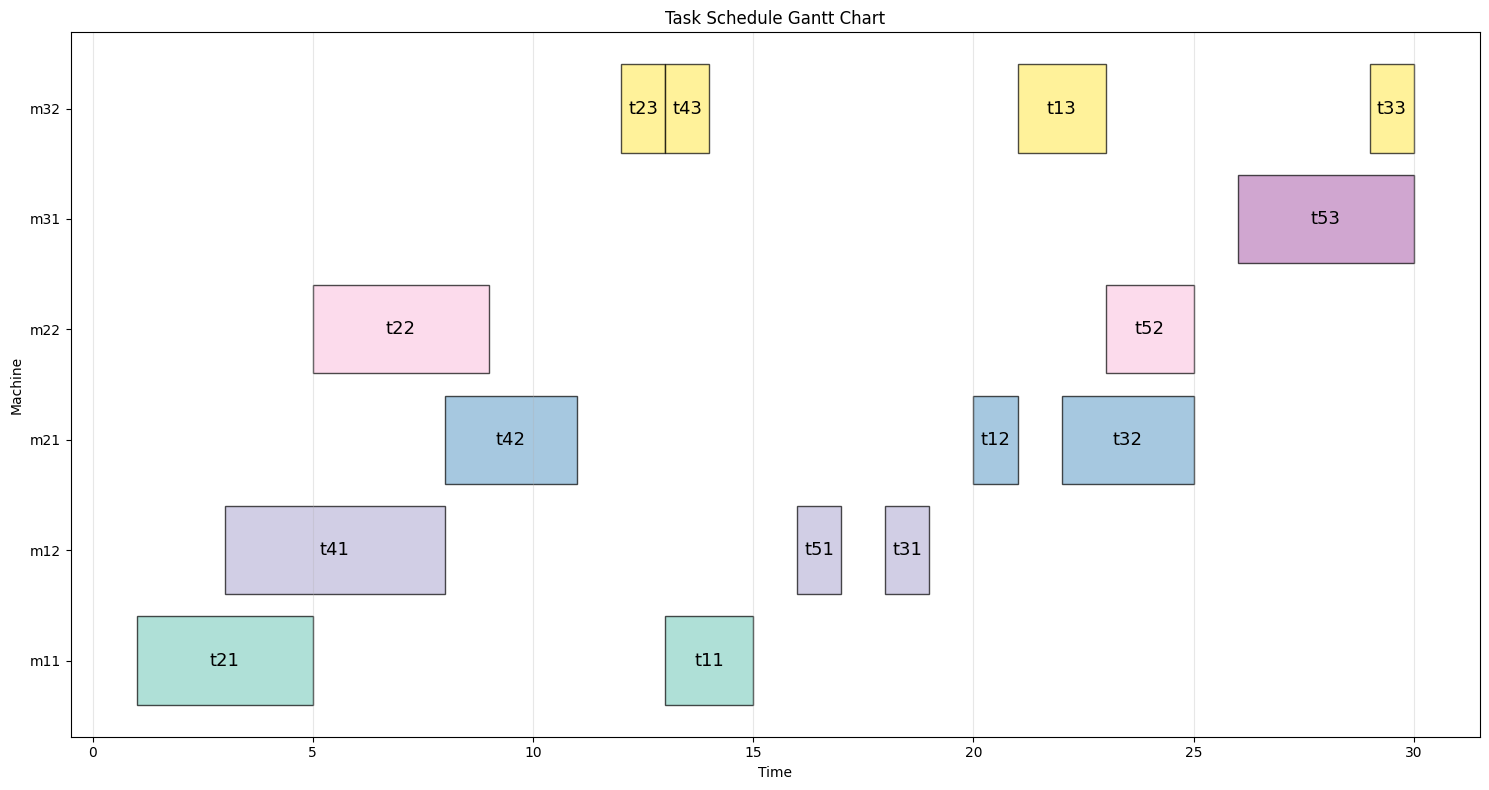

In [510]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

def create_gantt_chart(transition_num, sorted_task_schedule, sort_ans, job_tasks, machine_processing_time):
    # マシンのユニークリストを取得
    machines = sorted(list(set(sorted_task_schedule.values())))
    machine_to_idx = {machine: idx for idx, machine in enumerate(machines)}
    
    # タスクの開始時間とマシン割り当てを整理
    task_details = defaultdict(dict)
    
    # sort_ansからタスクの情報を取得
    for schedule in sort_ans:
        if isinstance(schedule, list):  # リストの場合のみ処理
            task_id = int(schedule[2])  # タスク番号
            start_time = int(schedule[1])  # 開始時刻
            
            # task_idに対応するタスク名を見つける
            task_name = None
            for task, tid in transition_num.items():
                if tid == task_id:
                    task_name = task
                    break
                    
            if task_name:
                task_details[task_name]['machine'] = sorted_task_schedule[task_name]
                task_details[task_name]['start'] = start_time
                task_details[task_name]['id'] = task_id
    
    # プロットの設定
    fig, ax = plt.subplots(figsize=(15, 8))
    
    # 色の設定
    colors = plt.cm.Set3(np.linspace(0, 1, len(machines)))
    machine_colors = dict(zip(machines, colors))
    
    # タスクをプロット
    for task, details in task_details.items():
        machine = details['machine']
        start_time = details['start']
        
        # タスクの処理時間を計算
        duration = math.ceil(job_tasks[task] / machine_processing_time[machine])
        
        # タスクの処理時間を表示
        print(f"Task {task}: Processing time = {duration}")
        
        ax.barh(y=machine_to_idx[machine],
                width=duration,
                left=start_time,
                color=machine_colors[machine],
                alpha=0.7,
                edgecolor='black')
        
        # タスク名をバーの中央に表示
        ax.text(start_time + duration / 2,
                machine_to_idx[machine],
                task,
                ha='center',
                va='center',
                fontsize=13)
    
    # グラフの装飾
    ax.set_yticks(range(len(machines)))
    ax.set_yticklabels(machines)
    ax.set_xlabel('Time')
    ax.set_ylabel('Machine')
    ax.set_title('Task Schedule Gantt Chart')
    
    # グリッド線の追加
    ax.grid(True, axis='x', alpha=0.3)
    
    # x軸の範囲を調整
    max_time = max(
        details['start'] + job_tasks[task] / machine_processing_time[details['machine']]
        for task, details in task_details.items()
    )
    ax.set_xlim(-0.5, max_time + 1.5)
    
    plt.tight_layout()
    return fig, ax

# タスクスケジュールの例
fig, ax = create_gantt_chart(transition_num, sorted_task_schedule, sort_ans, job_tasks, machine_processing_time)
plt.show()

# fig.savefig('./search/plots/gantt/1217/gantt1_1.png')